# Fall Problem Session 8
## Classifying Pumpkin Seeds II

In this notebook you continue to work with the pumpkin seed data from <a href="https://link.springer.com/article/10.1007/s10722-021-01226-0">The use of machine learning methods in classification of pumpkin seeds (Cucurbita pepo L.)</a> by Koklu, Sarigil and Ozbek (2021).

The problems in this notebook will cover the content covered in some of our `Classification` notebooks as well as some of our `Dimension Reduction` notebooks. In particular we will cover content touched on in:
- `Classification/Adjustments for Classification`,
- `Classification/k Nearest Neighbors`,
- `Classification/The Confusion Matrix`,
- `Classification/Logistic Regression`,
- `Classification/Diagnostic Curves`,
- `Classification/Bayes Based Classifiers` and
- `Dimension Reduction/Principal Components Analysis`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

#### 1. Load then prepare the data


- Load the data stored in `Pumpkin_Seeds_Dataset.xlsx` in the `Data` folder,
- Create a column `y` where `y=1` if `Class=Ürgüp Sivrisi` and `y=0` if `Class=Çerçevelik` and
- Make a train test split setting $10\%$ of the data aside as a test set.

##### Sample Solution

In [2]:
seeds = pd.read_excel("../Data/Pumpkin_Seeds_Dataset.xlsx")

seeds['y'] = 0

seeds.loc[seeds.Class=='Ürgüp Sivrisi', 'y']=1

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
seeds_train, seeds_test = train_test_split(seeds.copy(),
                                              shuffle=True,
                                              random_state=123,
                                              test_size=.1,
                                              stratify=seeds.y.values)

#### 2. Refresh your memory

If you need to refresh your memory on these data and the problem, you may want to look at a small subset of the data, look back on `Fall Problem Session 7` and/or browse Figure 5 and Table 1 of this paper, <a href="pumpkin_seed_paper.pdf">pumpkin_seed_paper.pdf</a>

##### Sample Solution

In [5]:
seeds_train.sample(5)

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Convex_Area,Equiv_Diameter,Eccentricity,Solidity,Extent,Roundness,Aspect_Ration,Compactness,Class,y
1017,93235,1216.567,490.9763,242.3947,94111,344.5439,0.8696,0.9907,0.6115,0.7916,2.0255,0.7018,Çerçevelik,0
2152,84359,1211.758,519.9932,207.1412,85081,327.7335,0.9172,0.9915,0.6489,0.7220,2.5103,0.6303,Ürgüp Sivrisi,1
1581,83376,1143.656,467.7990,227.3485,84065,325.8184,0.8740,0.9918,0.7485,0.8011,2.0576,0.6965,Ürgüp Sivrisi,1
2393,94070,1280.766,548.4586,218.8330,94801,346.0833,0.9170,0.9923,0.7266,0.7206,2.5063,0.6310,Ürgüp Sivrisi,1
446,76848,1042.813,393.8825,248.8834,77474,312.8033,0.7751,0.9919,0.7518,0.8880,1.5826,0.7942,Çerçevelik,0


#### 3. Principal components analysis (PCA)

One way you may use PCA is as a data preprocessing step for supervised learning tasks. In this problem you will try it as a preprocessing step for the pumpkin seed data and see if this preprocessing step helps your model outperform the models from `Fall Problem Session 7`.

##### a. 

Run the training data through PCA with two components and then plot the resulting principal values. Color each point by its class.

<i>Hint: Remember to scale the data before running it through PCA</i>.

##### Sample Solution

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [7]:
features = seeds_train.columns[:-2]

pca = Pipeline([('scale', StandardScaler()),
                   ('pca', PCA(2))])

fit = pca.fit_transform(seeds_train[features])

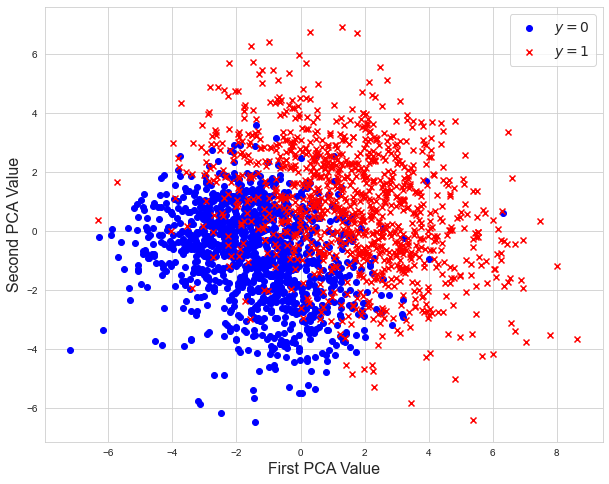

In [8]:
plt.figure(figsize=(10,8))

plt.scatter(fit[seeds_train.y==0, 0], 
            fit[seeds_train.y==0, 1],
            color = 'b',
            label="$y=0$")

plt.scatter(fit[seeds_train.y==1, 0], 
            fit[seeds_train.y==1, 1],
            color='r',
            marker='x',
            label="$y=1$")

plt.legend(fontsize=14)

plt.xlabel("First PCA Value", fontsize=16)
plt.ylabel("Second PCA Value", fontsize=16)

plt.show()

##### b.

How does the PCA with only two componenets appear to separate the data?

##### Sample Solution

While not perfect separation the two classes do seem to largely live in separate areas of the plot.

##### c.

Run 10-fold cross-validation below to find the optimal value of $k$ for a $k$ nearest neighbors model fit on the first and second PCA values. What is the optimal $k$ and the associated average cross-validation accuracy? How does this compare to the accuracies from `Fall Problem Session 7`?

##### Sample Solution

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [10]:
n_splits=10
kfold = StratifiedKFold(n_splits,
                           shuffle=True,
                           random_state=2013)

In [11]:
ks = range(1, 51)

pca_2_accs = np.zeros((n_splits, len(ks)))

i = 0
for train_index, test_index in kfold.split(seeds_train, seeds_train.y):
    seeds_tt = seeds_train.iloc[train_index]
    seeds_ho = seeds_train.iloc[test_index]
    
    j = 0
    for k in ks:
        pipe = Pipeline([('scale', StandardScaler()),
                               ('pca', PCA(2)),
                               ('knn', KNeighborsClassifier(k))])
        
        pipe.fit(seeds_tt[features].values,
                   seeds_tt.y.values)
        
        pred = pipe.predict(seeds_ho[features].values)
        
        pca_2_accs[i,j] = accuracy_score(seeds_ho.y.values, pred)
        
        j = j + 1
    i = i + 1

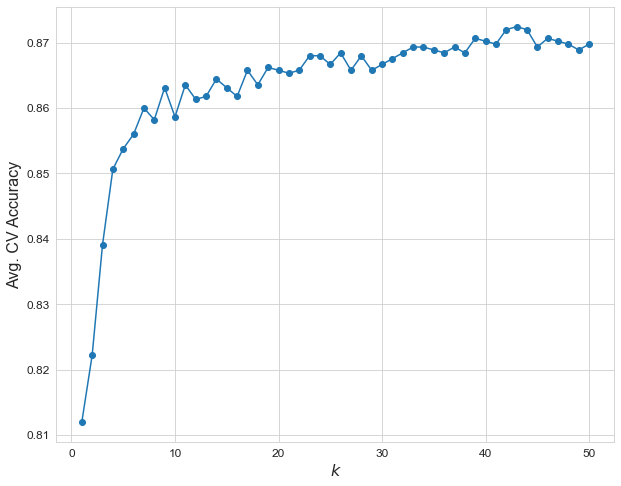

In [12]:
plt.figure(figsize=(10,8))


plt.plot(ks, 
         np.mean(pca_2_accs, axis=0),
         '-o')


plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("$k$", fontsize=16)
plt.ylabel("Avg. CV Accuracy", fontsize=16)

plt.show()

Looks like the optimal $k$ is $43$ with an average cross-validation accuracy a little above $87\%$. This seems to perform marginally better than the models I made in `Fall Problem Session 7`.

##### d.

We discussed examining the explained variance ratio as a way to determine how many components we may want to use in our PCA. We can also think of the explained variance as another hyperparameter we can tune through cross-validation.

Fill in the missing code below to find the optimal explained variance ratio and $k$ pairing for this problem. What is the best average cross-validation accuracy? How many components did you end up needing to achieve the highest average cross-validation accuracy?

##### Sample Solution

In [13]:
ks = range(1, 51)
explained_variances = np.arange(.09, 1, .1)

pca_accs = np.zeros((n_splits, len(ks), len(explained_variances)))

i = 0
for train_index, test_index in kfold.split(seeds_train, seeds_train.y):
    seeds_tt = seeds_train.iloc[train_index]
    seeds_ho = seeds_train.iloc[test_index]
    
    j = 0
    for neighbors in ks:
        k = 0
        for var in explained_variances:
            pipe = Pipeline([('scale', StandardScaler()),
                                   ('pca', PCA(var)),
                                   ('knn', KNeighborsClassifier(neighbors))])

            pipe.fit(seeds_tt[features].values,
                       seeds_tt.y.values)

            pred = pipe.predict(seeds_ho[features].values)

            pca_accs[i,j,k] = accuracy_score(seeds_ho.y.values, pred)
            k = k + 1
        j = j + 1
    i = i + 1

In [14]:
max_index = np.unravel_index(np.argmax(np.mean(pca_accs, axis=0), axis=None), 
                                       np.mean(pca_accs, axis=0).shape)


print("The pair with the highest AVG CV Accuracy was",
         "k =", ks[max_index[0]],
         "and explained variance =", np.round(explained_variances[max_index[1]],2))
print("The highest AVG CV Accuracy was", np.max(np.mean(pca_accs, axis=0)))

The pair with the highest AVG CV Accuracy was k = 37 and explained variance = 0.89
The highest AVG CV Accuracy was 0.8862222222222222


In [15]:
pca = Pipeline([('scale', StandardScaler()),
                                   ('pca', PCA(.89))])

pca.fit_transform(seeds_train[features]).shape

(2250, 3)

#### 4. Trying Bayes based classifiers

Build LDA, QDA and naive Bayes' models on these data by filling in the missing code for the cross-validation below. 

Do these outperform your PCA-$k$NN model from above?

##### Sample Solution

In [16]:
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [17]:
bayes_accs = np.zeros((n_splits, 3))


i = 0
for train_index, test_index in kfold.split(seeds_train, seeds_train.y):
    seeds_tt = seeds_train.iloc[train_index]
    seeds_ho = seeds_train.iloc[test_index]
    
    ## Linear Discriminant Analysis
    lda = Pipeline([('scale', StandardScaler()),
                    ('lda', LinearDiscriminantAnalysis())])
    
    lda.fit(seeds_tt[features].values,
               seeds_tt.y.values)
    lda_pred = lda.predict(seeds_ho[features].values)
    
    bayes_accs[i, 0] = accuracy_score(seeds_ho.y.values,
                                         lda_pred)
    
    ## Quadratic Discriminant Analysis
    qda = Pipeline([('scale', StandardScaler()),
                    ('qda', QuadraticDiscriminantAnalysis())])
    
    qda.fit(seeds_tt[features].values,
               seeds_tt.y.values)
    
    qda_pred = qda.predict(seeds_ho[features].values)
    
    bayes_accs[i, 1] = accuracy_score(seeds_ho.y.values,
                                         qda_pred)
    
    
    ## Gaussian Naive Bayes
    nb = Pipeline([('scale', StandardScaler()),
                    ('NB', GaussianNB())])
    
    nb.fit(seeds_tt[features].values,
              seeds_tt.y.values)
    
    nb_pred = nb.predict(seeds_ho[features].values)
    
    bayes_accs[i, 2] = accuracy_score(seeds_ho.y.values,
                                         nb_pred)
    
    i = i + 1

In [18]:
np.mean(bayes_accs, axis=0)

array([0.87911111, 0.884     , 0.87155556])

Comparable to the PCA-$k$nn model.

#### 5. LDA for supervised dimensionality reduction

While we introduced linear discriminant analysis (LDA) as a classification algorithm, it was originally proposed by Fisher as a supervised dimension reduction technique, <a href="https://digital.library.adelaide.edu.au/dspace/bitstream/2440/15227/1/138.pdf">https://digital.library.adelaide.edu.au/dspace/bitstream/2440/15227/1/138.pdf</a>. In particular, the initial goal was to project the features, $X$, corresponding to a binary output, $y$, onto a single dimension which best separates the possible classes. This single dimension has come to been known as <i>Fisher's discriminant</i>.

Walk through the code below to perform this supervised dimension reduction technique on these data

##### a.

First make a validation set from the training set for demonstration purposes.

##### Sample Solution

In [19]:
## First we make a validation set for demonstration purposes
seed_tt, seeds_val = train_test_split(seeds_train.copy(),
                                               shuffle=True,
                                               random_state=302,
                                               test_size = .2,
                                               stratify = seeds_train.y)

##### b.

Now make a pipeline that first scales the data and ends with linear discriminant analysis. Then fit the pipeline.

##### Sample Solution

In [20]:
pipe = Pipeline([('scale', StandardScaler()),
                    ('lda', LinearDiscriminantAnalysis())])

In [21]:
pipe.fit(seeds_tt[features], 
         seeds_tt.y.values)

Pipeline(steps=[('scale', StandardScaler()),
                ('lda', LinearDiscriminantAnalysis())])

##### c. 

Now calculate the Fisher discriminant by using `transform` with the pipeline you fit in <i>b.</i>

##### Sample Solution

In [22]:
fish = pipe.transform(seeds_tt[features])
fish

array([[-0.62023389],
       [ 0.54965908],
       [ 2.5477464 ],
       ...,
       [-0.9233007 ],
       [-0.04377934],
       [-2.66434718]])

##### d. 

To visualize how LDA separated the two classes while projecting the 12 dimensional data onto a one dimensional subspace you can plot a histogram of the Fisher discriminant colored by the pumpkin seed class of the observation.

##### Sample Solution

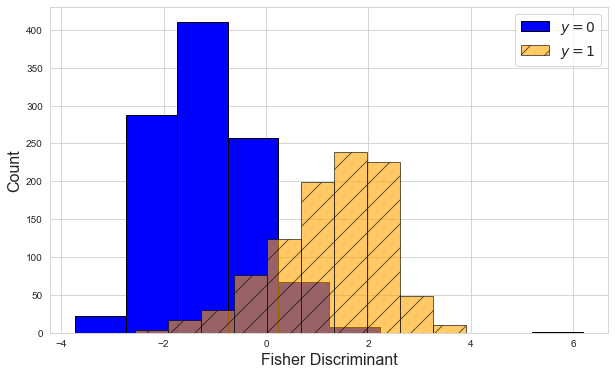

In [23]:
plt.figure(figsize=(10,6))

plt.hist(fish[seeds_tt.y==0], 
         color='blue',
         edgecolor="black",
         label="$y=0$")

plt.hist(fish[seeds_tt.y==1], 
         color='orange', 
         hatch='/', 
         alpha=.6,
         edgecolor="black",
         label="$y=1$")

plt.xlabel("Fisher Discriminant", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.legend(fontsize=14)

plt.show()

##### e.

While there is some separation between the two classes, it is not perfect, this should be expected based on the exploratory data analysis you did in `Fall Problem Session 7`.

We could use this discriminant in order to make classifications, for example by setting a simple cutoff value or as input into a different classification algorithm.

However, it is important to note that the LDA algorithm maximizes the separation of the two classes among observations of the training set. It is possible that separation would not be as good for data the algorithm was not trained on.

In this example we can visually inspect by plotting a histogram of the Fisher discriminant values for the validation set we created. Does the separation seem as pronounced on the validation data?

##### Sample Solution

In [24]:
fish_val = pipe.transform(seeds_val[features])

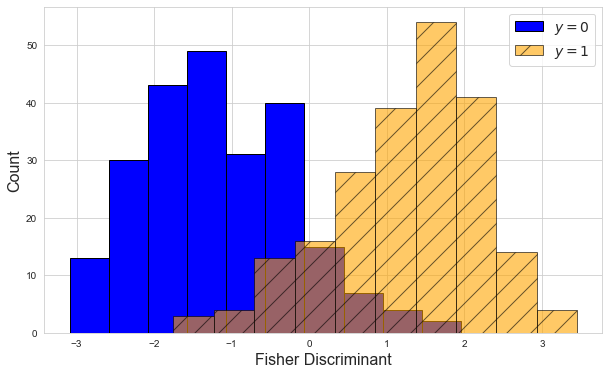

In [25]:
plt.figure(figsize=(10,6))

plt.hist(fish_val[seeds_val.y==0], 
         color='blue',
         edgecolor="black",
         label="$y=0$")

plt.hist(fish_val[seeds_val.y==1], 
         color='orange', 
         hatch='/', 
         alpha=.6,
         edgecolor="black",
         label="$y=1$")

plt.xlabel("Fisher Discriminant", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.legend(fontsize=14)

plt.show()

There appears to be a little more overlap, but overall the separation appears similar on the validation set.

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2022.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)